Importing necessary libraries for loading and preprocessing data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Setting display settings for better understanding of outputs and visualisations

In [ ]:
pd.get_option("display.max_columns")
sns.set(rc={'figure.figsize':(11.7,8.27)})

Some preliminary exploration with the data

In [5]:
train = pd.read_csv("/content/drive/MyDrive/Datasets/Kaggle_Training_Dataset_v2.csv")
test = pd.read_csv("/content/drive/MyDrive/Datasets/Kaggle_Test_Dataset_v2.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train.shape

(1687861, 23)

In [ ]:
train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No


In [ ]:
test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


In [ ]:
train.dtypes

sku                   object
national_inv         float64
lead_time            float64
in_transit_qty       float64
forecast_3_month     float64
forecast_6_month     float64
forecast_9_month     float64
sales_1_month        float64
sales_3_month        float64
sales_6_month        float64
sales_9_month        float64
min_bank             float64
potential_issue       object
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

The sku column which stands for Stock Keeping Unit is just a unique identifier and thus, can be removed as it has no effect on the outcome of the entry

In [6]:
train = train.drop(['sku'], axis=1)
test = test.drop(['sku'], axis=1)

We extract the categorical variables for separate processing

In [7]:
s = (train.dtypes == 'object')
cat_var = list(s[s].index)
print(cat_var)

['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']


In [ ]:
train.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


From the table above, we see that national_inv, perf_6_month_avg and perf_12_month_avg have negative min values. We explore these values to identify their significance.

In [ ]:
train.loc[train['national_inv'] < 0.0]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
176,-55.0,8.0,2.0,428.0,526.0,606.0,25.0,100.0,205.0,387.0,52.0,No,0.0,-99.00,-99.00,56.0,No,No,No,Yes,No,Yes
191,-499.0,12.0,350.0,3452.0,5044.0,7188.0,747.0,2550.0,3572.0,4745.0,401.0,No,0.0,0.49,0.72,525.0,No,No,No,Yes,No,Yes
342,-48.0,8.0,97.0,67.0,85.0,115.0,19.0,87.0,165.0,199.0,14.0,No,0.0,0.47,0.47,60.0,Yes,No,No,Yes,No,No
552,-1.0,12.0,0.0,6.0,6.0,6.0,0.0,1.0,2.0,2.0,0.0,No,0.0,0.82,0.79,1.0,No,No,No,Yes,No,No
916,-94.0,9.0,80.0,5.0,8.0,8.0,205.0,205.0,205.0,205.0,0.0,No,0.0,0.91,0.74,0.0,No,No,No,Yes,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687847,-206.0,NaN,0.0,760.0,1145.0,1453.0,114.0,853.0,1764.0,2706.0,0.0,No,0.0,-99.00,-99.00,206.0,Yes,No,No,Yes,No,No
1687850,-2.0,NaN,0.0,0.0,62.0,86.0,6.0,32.0,46.0,57.0,2.0,No,0.0,-99.00,-99.00,32.0,Yes,No,No,No,No,No
1687851,-6.0,9.0,36.0,130.0,130.0,130.0,0.0,0.0,54.0,57.0,3.0,No,0.0,0.03,0.10,42.0,No,No,No,Yes,No,No
1687856,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No


In [ ]:
train[train['perf_6_month_avg'] < 0.0].perf_6_month_avg.value_counts()

-99.0    129478
Name: perf_6_month_avg, dtype: int64

In [ ]:
train[train['perf_12_month_avg'] < 0.0].perf_12_month_avg.value_counts()

-99.0    122050
Name: perf_12_month_avg, dtype: int64

It appears like the negative values for national_inv represent a shortage/excess of inventory whereas for perf_6_month_avg and perf_12_month_avg, there is only one negative value of -99. It is fair to assume that this represents missing data. Thus, we replace the -99 values in both these columns with NaN to find this another way.

In [8]:
train['perf_6_month_avg'].replace(-99.0, np.NaN, inplace=True)
train['perf_12_month_avg'].replace(-99.0, np.NaN, inplace=True)
test['perf_6_month_avg'].replace(-99.0, np.NaN, inplace=True)
test['perf_12_month_avg'].replace(-99.0, np.NaN, inplace=True)

In [9]:
train.isna().sum()

national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg     129479
perf_12_month_avg    122051
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

It appears that there is one row that has multiple nan values and this row can be deleted, we find which row it is by tracing it with the label/class column.

In [ ]:
train[train['went_on_backorder'].isnull()]

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears it is the final row. We can rid of this final row by doing this and we check for nulls again after removing the last row:

In [10]:
train = train[:-1]

We check if the same pattern is recurrent in the test data as well

In [11]:
test.isna().sum()

national_inv             1
lead_time            14725
in_transit_qty           1
forecast_3_month         1
forecast_6_month         1
forecast_9_month         1
sales_1_month            1
sales_3_month            1
sales_6_month            1
sales_9_month            1
min_bank                 1
potential_issue          1
pieces_past_due          1
perf_6_month_avg     19102
perf_12_month_avg    17976
local_bo_qty             1
deck_risk                1
oe_constraint            1
ppap_risk                1
stop_auto_buy            1
rev_stop                 1
went_on_backorder        1
dtype: int64

In [ ]:
test.tail()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
242071,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242072,13.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242073,10.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242074,2913.0,12.0,0.0,0.0,0.0,0.0,0.0,30.0,88.0,88.0,4.0,No,0.0,0.48,0.48,0.0,Yes,No,No,Yes,No,No
242075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again the last row is filled with NaN values in test data as well and we remove this row. 

In [12]:
test = test[:-1]

We also look at the distribution of values in the categorical columns

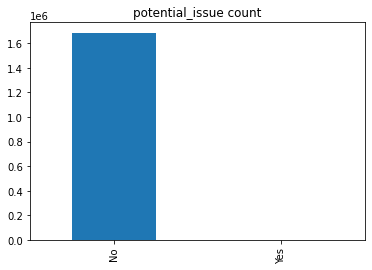

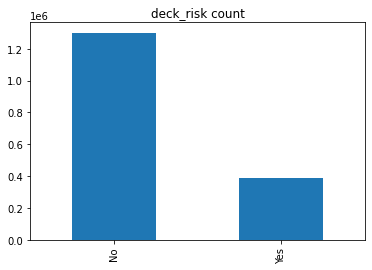

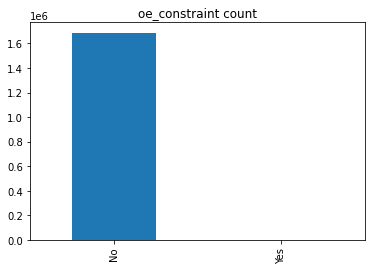

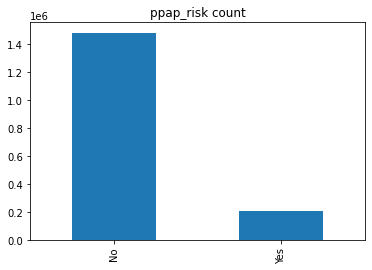

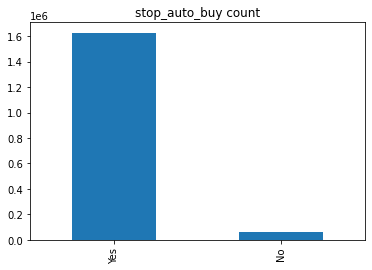

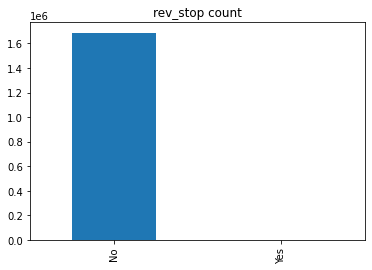

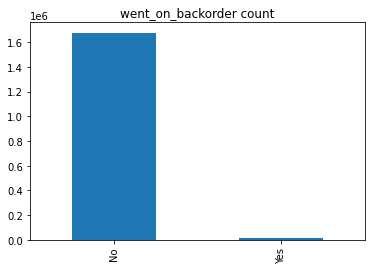

In [16]:
for x in cat_var:
  plt.figure()
  train[x].value_counts().plot.bar(title=x+" count")

Now we move to convert categorical variable into indicator variables to prepare the data for impute functions

In [13]:
train = pd.get_dummies(data=train, columns=cat_var, drop_first=True)
test = pd.get_dummies(data=test, columns=cat_var, drop_first=True)

In [14]:
### As the label was also categorical, it gets encoded and needs to be renamed
train.rename(columns = {'went_on_backorder_Yes':'went_on_backorder'}, inplace = True)
test.rename(columns = {'went_on_backorder_Yes':'went_on_backorder'}, inplace = True)

Now, we replace the missing data with the help of Iterative Imputer

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(train)
train_df = imputer.transform(train)

In [16]:
imputer.fit(test)
test_df = imputer.transform(test)

In [17]:
# The Iterative Imputer returns an ndarray and we convert it back to a Pandas df with the following.
train = pd.DataFrame(data = train_df, columns = train.columns)
test = pd.DataFrame(data = test_df, columns = train.columns)

Now we figure out correlation between variables to eliminate variables that are too closely related

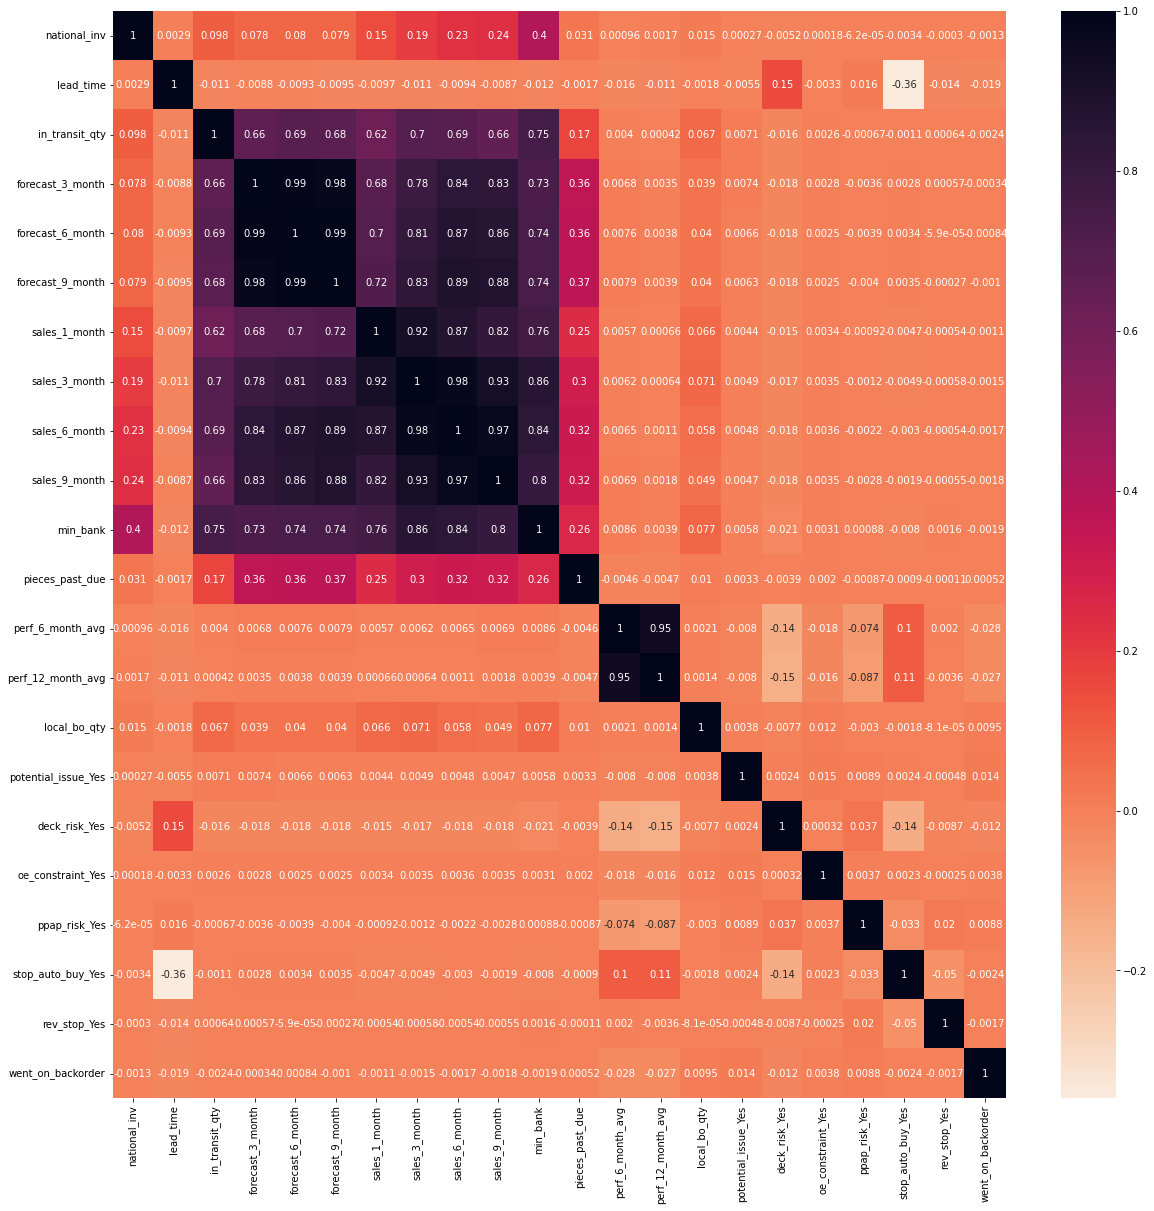

In [26]:
corrMatrix = train.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True, cmap="rocket_r")
plt.show()

We define a function that finds out features that are too correlated and thus can be removed from the data.

In [18]:
def correlation(dataset, threshold):
  col_corr = set()  # Set of all the names of correlated columns
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i, j]) > threshold:
        colname = corr_matrix.columns[i]  # getting the name of column
        col_corr.add(colname)
  return col_corr

In [19]:
### We apply the function on our training data with a tcorrelation hreshold of 80%
rel_cols = correlation(train, 0.8)

In [46]:
### We find that the following features are dispensable
rel_cols

{'forecast_6_month',
 'forecast_9_month',
 'min_bank',
 'perf_12_month_avg',
 'sales_3_month',
 'sales_6_month',
 'sales_9_month'}

We convert the set into a list in order to be able to pass it into the drop function to remove the columns from both training and test data

In [20]:
rel_cols = list(rel_cols)
train = train.drop(rel_cols, axis=1)
test = test.drop(rel_cols, axis=1)

Check for null values in train data

In [21]:
train.isna().sum()

national_inv           0
lead_time              0
in_transit_qty         0
forecast_3_month       0
sales_1_month          0
pieces_past_due        0
perf_6_month_avg       0
local_bo_qty           0
potential_issue_Yes    0
deck_risk_Yes          0
oe_constraint_Yes      0
ppap_risk_Yes          0
stop_auto_buy_Yes      0
rev_stop_Yes           0
went_on_backorder      0
dtype: int64

With no missing values, now we split the labels from the the data

In [22]:
X = train.drop(['went_on_backorder'], axis=1)
y = train['went_on_backorder']

X_test = test.drop(['went_on_backorder'], axis=1)
y_test = test['went_on_backorder']

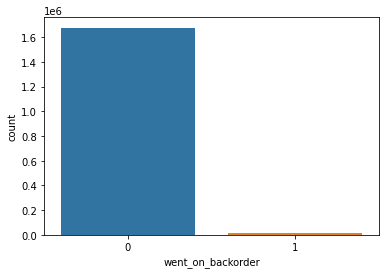

In [ ]:
sns.countplot(x=train['went_on_backorder'],label="Count")
plt.show()

As the dataset is highly imbalanced, we can get it balanced by oversampling. 

In [23]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=42)

In [24]:
X_train, y_train = os.fit_resample(X,y)

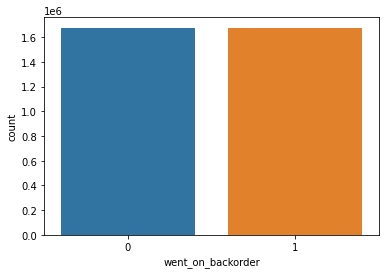

In [ ]:
sns.countplot(x=y_train,label="Count")
plt.show()

In [ ]:
X_train.shape, y_train.shape

((3353134, 14), (3353134,))

We scale the data in order to be able to feed it to algorithms that require scaled data

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled= sc.transform(X_train)
sc.fit(X_test)
X_test_scaled= sc.transform(X_test)

Import the algorithms that we want to train the model on. We import Random Forest, Logistic Regression and KNN from CuML as CuML runs them on GPU and takes less time. 

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from cuml.ensemble import RandomForestClassifier
from cuml.neighbors import KNeighborsClassifier
from cuml.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from cuml.metrics.accuracy import accuracy_score

In order to find the right k value for KNN algorithm, we run iterations with different k values to find the one with the least error rate.

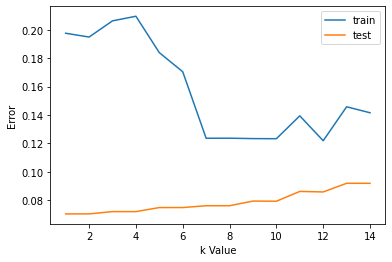

In [ ]:
error1= []
error2= []
for k in range(1,15):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred1= knn.predict(X_train_scaled)
    error1.append(np.mean(y_train!= y_pred1))
    y_pred2= knn.predict(X_test_scaled)
    error2.append(np.mean(y_test!= y_pred2))
plt.plot(range(1,15),error1,label="train")
plt.plot(range(1,15),error2,label="test")
plt.xlabel('k Value')
plt.ylabel('Error')
plt.legend()

We see that the lowest rate of error comes at 7 and the values remain consistent after that and we see a dip at 12, but it is not recommended to use an even number for the k value and thus we go with 7. 

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
dtree = DecisionTreeClassifier(criterion='entropy', random_state=10)
randomforest = RandomForestClassifier(n_estimators=100)
knn = KNeighborsClassifier(n_neighbors=7)
sgd = SGDClassifier(max_iter=500, tol=1e-3, random_state=45)
gnb = GaussianNB()
lr = LogisticRegression(max_iter=2000)

algos={'Decision Tree': dtree,
       'Random Forest': randomforest,
       'K-Nearest Neighbours': knn,
       'Stochastic Gradient Descent': sgd,
       'Gaussian Naive Bayes': gnb,
       'Logistic Regression': lr,
       }
accuracies = dict()

for name, algo in algos.items():
  if name == 'Gaussian Naive Bayes':
    algo.fit(X_train_scaled, y_train)
    y_pred= algo.predict(X_test_scaled)
  else:
    algo.fit(X_train, y_train)
    y_pred= algo.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  accuracies[name] = round(acc,4)
  print("{}'s accuracy: {:.4f}".format(name,acc))

Decision Tree's accuracy: 0.9708
Random Forest's accuracy: 0.9168
K-Nearest Neighbours's accuracy: 0.9340
Stochastic Gradient Descent's accuracy: 0.6308
Gaussian Naive Bayes's accuracy: 0.9889
Logistic Regression's accuracy: 0.6184


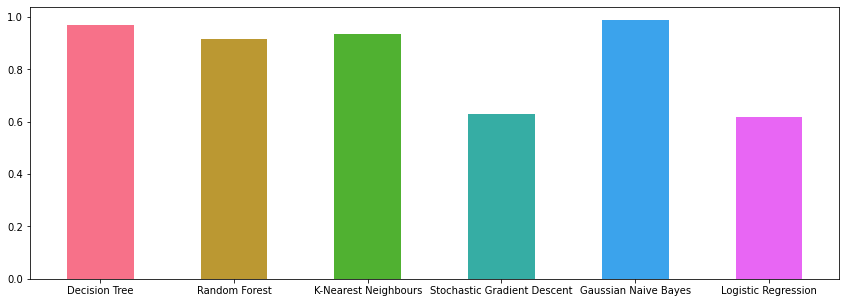

In [34]:
#plt.bar(accuracies.keys(), accuracies.values(), 1.0, color='g')
plt.figure(figsize=(14.5,5))
ind = np.arange(len(accuracies))
palette = sns.color_palette("husl", len(accuracies))
plt.bar(ind, list(accuracies.values()), 0.5, color=palette)
plt.xticks(ind, list(accuracies.keys()))
plt.show()